In [446]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 24

hours = np.arange(7, 22)
busy = np.array([ 5, 15, 30, 20, 30, 55, 80, 45, 25, 20, 25, 40, 25, 20, 10])
idle = np.array([25, 20, 10, 25, 30, 20, 10, 35, 45, 45, 25, 15, 20, 15, 20])
optimal = (busy / 0.8).astype(np.int)
print(np.sum(busy) / (np.sum(busy) + np.sum(idle)))
print(np.sum(busy) / (np.sum(optimal)))

0.5527950310559007
0.8061594202898551


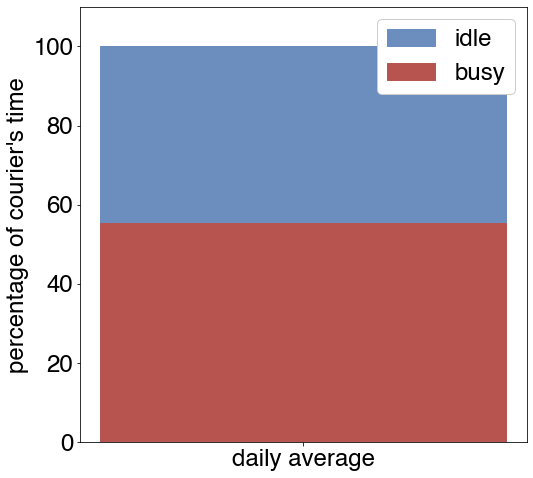

In [459]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_ylabel('percentage of courier\'s time')
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(["daily average"], 100 * np.sum(idle) / (np.sum(busy) + np.sum(idle)), width = 1, bottom = 100 * np.sum(busy) / (np.sum(busy) + np.sum(idle)), label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(["daily average"], 100 * np.sum(busy) / (np.sum(busy) + np.sum(idle)), width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
ax.legend(loc = 'upper right', facecolor = 'white', framealpha = 1)
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-zoom-out.svg')

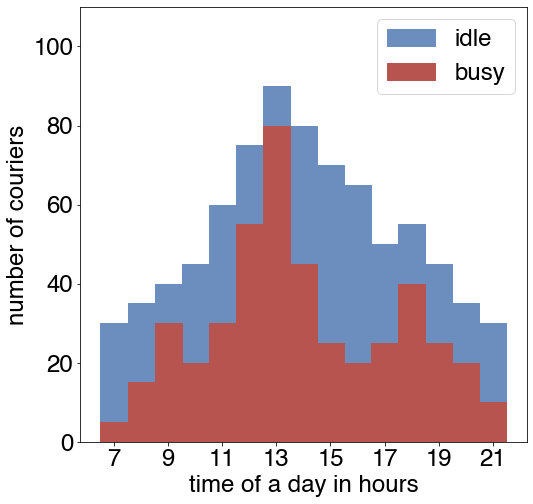

In [460]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_xlabel('time of a day in hours')
ax.set_ylabel('number of couriers') 
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(hours, idle, width = 1, bottom = busy, label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(hours, busy, width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
plt.xticks(np.delete(hours, np.arange(1, hours.size, 2))) 
ax.legend(loc = 'upper right')
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-zoom-in.svg')

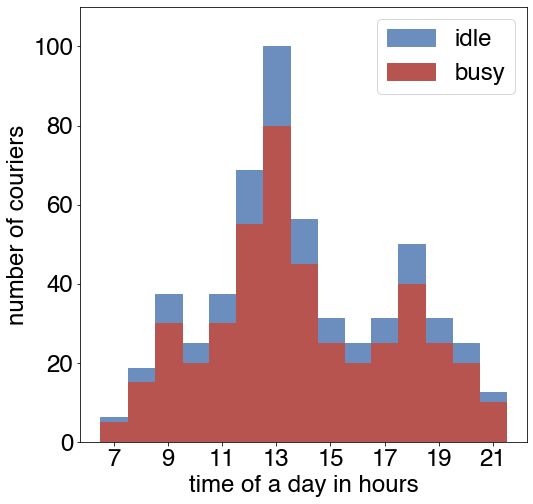

In [461]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_xlabel('time of a day in hours')
ax.set_ylabel('number of couriers')
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(hours, (busy / 0.8) - busy, width = 1, bottom = busy, label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(hours, busy, width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
plt.xticks(np.delete(hours, np.arange(1, hours.size, 2)))
ax.legend(loc = 'upper right')
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-ideal.svg')

     con: array([1.20583543e-10, 4.09976053e-10, 8.68077166e-10, 5.78790349e-10,
       8.68034533e-10, 1.61551839e-09, 2.36317987e-09, 1.30211220e-09,
       6.99234448e-10, 5.78825876e-10, 7.23535010e-10, 1.18168231e-09,
       7.23598959e-10, 5.78790349e-10, 2.65368172e-10])
     fun: 652.9999999990421
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([2.85269046e+01, 2.64730954e+01, 2.25269046e+01, 1.05269046e+01,
       3.50208363e-10, 3.52690462e+00, 3.50208363e-10, 8.93367727e-10,
       1.05352820e-10, 8.36606542e-10, 2.40000000e+01, 1.47309538e+00,
       3.10120678e-10, 6.92260123e-10, 3.10120678e-10, 1.47309538e+00,
       1.44730954e+01, 5.59391755e-10, 4.71485827e-10, 8.47309538e+00,
       1.60823992e-10, 8.47309538e+00, 3.94730954e+01, 4.50000000e+01,
       1.00000000e+00, 4.69311636e-10, 4.07903839e-10, 4.52690462e+00,
       2.35269046e+01, 4.52690462e+00, 4.07903839e-10, 5.09024

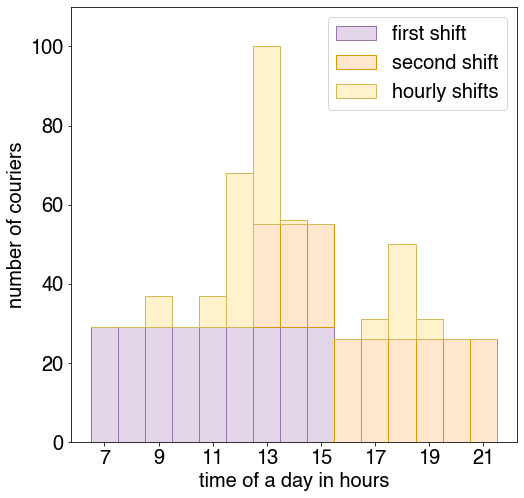

In [426]:
def solve_better(required_supply, max_part_time_per_hour, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = 1
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = 1
    slack_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(slack_time, -1)
    part_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(part_time, 1)
    A_eq = np.vstack((full_time, slack_time, part_time)).transpose()
    B_eq = required_supply
    c = np.concatenate((np.full((np.size(full_time, 0)), 8), np.full(np.size(slack_time, 0), 1), np.full(np.size(part_time, 0), 1)), axis=0)
#     print(A_eq)
#     print(B_eq)
#     print(c)
    x_bounds = np.concatenate(([[0, 100]] * (np.size(full_time, 0) + np.size(slack_time, 0)), [[0, max_part_time_per_hour]] * np.size(part_time, 0)))
#     print(x_bounds)
#     x_bounds = None
    res = linprog(c, A_eq = A_eq, b_eq = B_eq, bounds = x_bounds, method = 'interior-point')
    print(res)
    return np.round(np.array(res.x))

def plot_better(shifts, ideal, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = shifts[0]
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = shifts[1]
    part_time = np.zeros((hours.size, hours.size))
    row, col = np.diag_indices(part_time.shape[0])
    part_time[row, col] = shifts[(2 + hours.size):]
#     print(part_time)
    all_time = np.concatenate([full_time, part_time])
    print(np.sum(busy) / np.sum(all_time))
    _, ax = plt.subplots(figsize = (8, 8))
    ax.set_xlabel('time of a day in hours')
    ax.set_ylabel('number of couriers')
    ax.set_ylim(0, max(np.sum(full_time, axis = 0) + np.sum(part_time, axis = 0)) + 10)
    ax.bar(hours, full_time[0], width = 1, color = '#E1D5E7', edgecolor = '#9673A6', label = 'first shift')
    ax.bar(hours, full_time[1], width = 1, bottom = full_time[0], color = '#FFE6CC', edgecolor = '#D79B00', label = 'second shift')
    ax.bar(hours, np.sum(part_time, axis = 0), width = 1, bottom = np.sum(full_time, axis = 0), color = '#FFF2CC', edgecolor = '#D6B656', label = 'hourly shifts')
#     ax.plot(hours, ideal, linewidth = 4, linestyle = 'dashed', color = '#82B366')
    ax.legend(loc = 'upper right')
    plt.xticks(np.delete(hours, np.arange(1, hours.size, 2)))
    plt.savefig('shifts.svg')

plot_better(solve_better(optimal, 45), optimal)

     con: array([ 3.93248957, 15.72995826, 34.4092837 , 22.61181501, 34.4092837 ,
       64.88607784, 95.36287197, 52.10548675, 27.52742696, 22.611815  ,
       28.51054935, 47.18987479, 28.51054935, 22.611815  ,  9.83122391])
     fun: 39.328576610987376
 message: 'The algorithm terminated successfully and determined that the problem is infeasible.'
     nit: 5
   slack: array([], dtype=float64)
  status: 2
 success: False
       x: array([0.49314525, 1.93775697, 1.57436518, 1.77689648, 2.09757104,
       1.89503974, 2.09757104, 2.6207769 , 2.20622581, 1.46361103,
       1.04167082, 0.45042803, 0.55169368, 0.87236824, 0.55169368,
       0.45042803, 0.23101912])
11.710526315789474


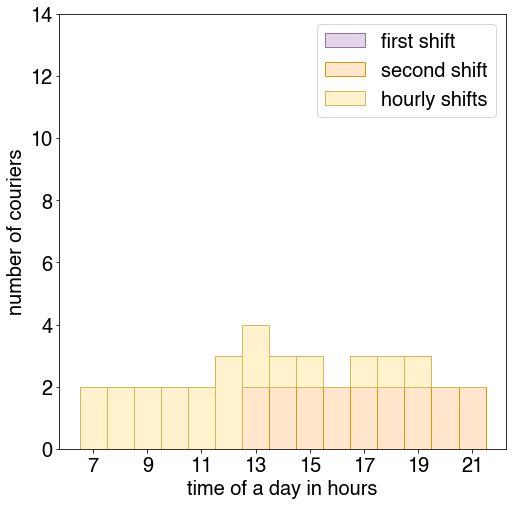

In [425]:
def solve_better(required_supply, max_part_time_per_hour, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = 1
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = 1
    part_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(part_time, 1)
    A_eq = np.vstack((full_time, part_time)).transpose()
    B_eq = required_supply
    c = np.concatenate((np.full((np.size(full_time, 0)), 8), np.full(np.size(part_time, 0), 1)), axis=0)
    x_bounds = np.concatenate(([[0, 100]] * np.size(full_time, 0), [[0, max_part_time_per_hour]] * np.size(part_time, 0)))
#     print(x_bounds)
#     x_bounds = None
    res = linprog(c, A_eq = A_eq, b_eq = B_eq, bounds = x_bounds, method = 'interior-point')
    print(res)
    return np.round(np.array(res.x))

def plot_better(shifts, ideal, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = shifts[0]
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = shifts[1]
    part_time = np.zeros((hours.size, hours.size))
    row, col = np.diag_indices(part_time.shape[0])
    part_time[row, col] = shifts[2:]
#     print(part_time)
    all_time = np.concatenate([full_time, part_time])
    print(np.sum(busy) / np.sum(all_time))
    _, ax = plt.subplots(figsize = (8, 8))
    ax.set_xlabel('time of a day in hours')
    ax.set_ylabel('number of couriers')
    ax.set_ylim(0, max(np.sum(full_time, axis = 0) + np.sum(part_time, axis = 0)) + 10)
    ax.bar(hours, full_time[0], width = 1, color = '#E1D5E7', edgecolor = '#9673A6', label = 'first shift')
    ax.bar(hours, full_time[1], width = 1, bottom = full_time[0], color = '#FFE6CC', edgecolor = '#D79B00', label = 'second shift')
    ax.bar(hours, np.sum(part_time, axis = 0), width = 1, bottom = np.sum(full_time, axis = 0), color = '#FFF2CC', edgecolor = '#D6B656', label = 'hourly shifts')
#     ax.plot(hours, ideal, linewidth = 4, linestyle = 'dashed', color = '#82B366')
    ax.legend(loc = 'upper right')
    plt.xticks(np.delete(hours, np.arange(1, hours.size, 2)))
    plt.savefig('shifts.svg')

plot_better(solve_better(optimal, 45), optimal)